In [74]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [75]:
# Load JSON data
with open('gpt4_response_1000.json') as f:
    data = json.load(f)

# Initialize a list to hold our row data
rows = []

# Iterate over each element in the JSON data to create a row for the DataFrame
for item in data:
    row = {
        'example_id': item['example_id'],
        'question': item['question'],
        'question_length': item['question_length'],
        'reference': item['reference'],
        'response-0': item['response-0'],
        'response-1': item['response-1'],
        'response-2': item['response-2'],
        'response-3': item['response-3'],
        # Placeholder for SEMSCORES, to be calculated
        'ref_to_res-0_score': None,
        'res-0_to_res-1_score': None,
        'res-0_to_res-2_score': None,
        'res-0_to_res-3_score': None,
    }
    rows.append(row)

# Create the DataFrame
df = pd.DataFrame(rows)

# Display the DataFrame to verify it looks correct
print(df.head())


            example_id                                           question  \
0  6915606477668963399                    what do the 3 dots mean in math   
1 -8366545547296627039       who wrote the song photograph by ringo starr   
2 -5004457603684974952  who is playing the halftime show at super bowl...   
3  8494342737238168262        star wars the clone wars anakin voice actor   
4  8030523471764209741          where is most distortion found on a globe   

   question_length                                          reference  \
0                8  In logical argument and mathematical proof , t...   
1                8  `` Photograph '' UK picture sleeve Single by R...   
2               10  The Super Bowl 50 Halftime Show took place on ...   
3                8  In December 2006 , he was announced to voice t...   
4                8  Flat maps are created using a map projection t...   

                                          response-0  \
0  The three dots in math can have a few d

In [76]:
df['question_length'].describe()

count    1000.000000
mean        9.272000
std         1.809777
min         8.000000
25%         8.000000
50%         9.000000
75%        10.000000
max        22.000000
Name: question_length, dtype: float64

In [77]:
model = SentenceTransformer('all-mpnet-base-v2')

def batch_semscore(reference_texts, response_texts):
    # Ensure inputs are numpy arrays for easier batch processing
    reference_texts = np.array(reference_texts)
    response_texts = np.array(response_texts)

    # Compute embeddings for both sets of texts in batches
    reference_embeddings = model.encode(reference_texts, show_progress_bar=True)
    response_embeddings = model.encode(response_texts, show_progress_bar=True)

    # Compute cosine similarity between each pair of reference and response
    # The output is a similarity matrix of shape [len(reference_texts), len(response_texts)]
    similarity_scores = cosine_similarity(reference_embeddings, response_embeddings)
    
    # Extract the diagonal elements to get the similarity scores for corresponding pairs
    scores = np.diag(similarity_scores)
    
    return scores

In [78]:
df['ref_to_res-0_score'] = batch_semscore(df['reference'], df['response-0'])
df['res-0_to_res-1_score'] = batch_semscore(df['response-0'], df['response-1'])
df['res-0_to_res-2_score'] = batch_semscore(df['response-0'], df['response-2'])
df['res-0_to_res-3_score'] = batch_semscore(df['response-0'], df['response-3'])

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [79]:
df.to_csv('gpt4_responses_1000.csv', index=False)

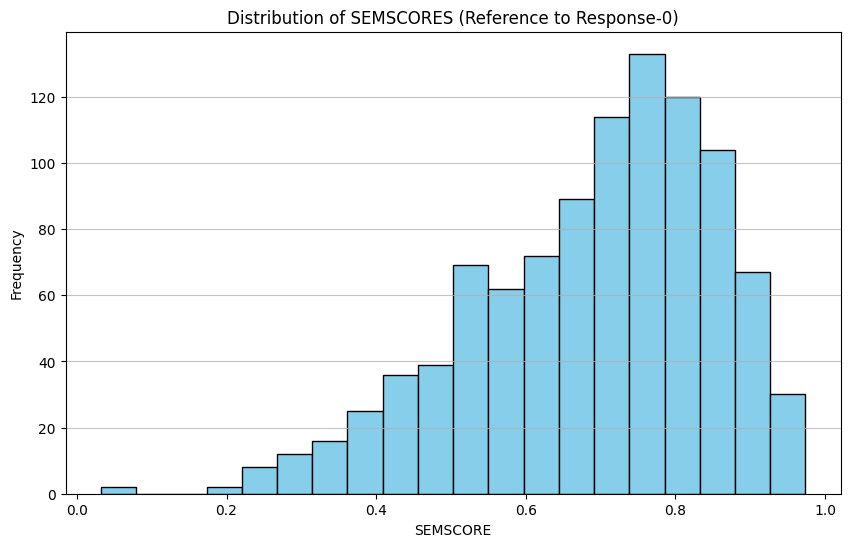

count    1000.000000
mean        0.688880
std         0.163793
min         0.032023
25%         0.577345
50%         0.716880
75%         0.811462
max         0.973830
Name: ref_to_res-0_score, dtype: float64

In [80]:
# Plot the distribution of SEMSCORES between reference and response-0

plt.figure(figsize=(10, 6))
plt.hist(df['ref_to_res-0_score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of SEMSCORES (Reference to Response-0)')
plt.xlabel('SEMSCORE')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()

# Summary statistics for 'ref_to_res-0_score'
summary_statistics = df['ref_to_res-0_score'].describe()
summary_statistics


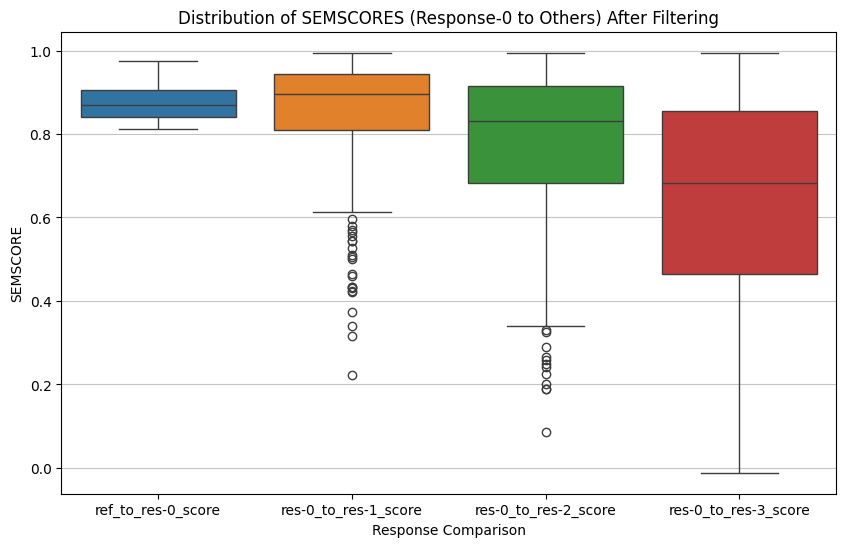

In [82]:
# Step 1: Calculate the 75th percentile for 'ref_to_res-0_score'
percentile_75 = df['ref_to_res-0_score'].quantile(0.75)

# Step 2: Filter the DataFrame
filtered_df = df[df['ref_to_res-0_score'] >= percentile_75]

# Step 3: Plotting the box plot
# Prepare the data for the box plot
scores_data = filtered_df[['ref_to_res-0_score', 'res-0_to_res-1_score', 'res-0_to_res-2_score', 'res-0_to_res-3_score']]

plt.figure(figsize=(10, 6))
sns.boxplot(data=scores_data)
plt.title('Distribution of SEMSCORES (Response-0 to Others) After Filtering')
plt.ylabel('SEMSCORE')
plt.xlabel('Response Comparison')
plt.grid(axis='y', alpha=0.75)

plt.show()


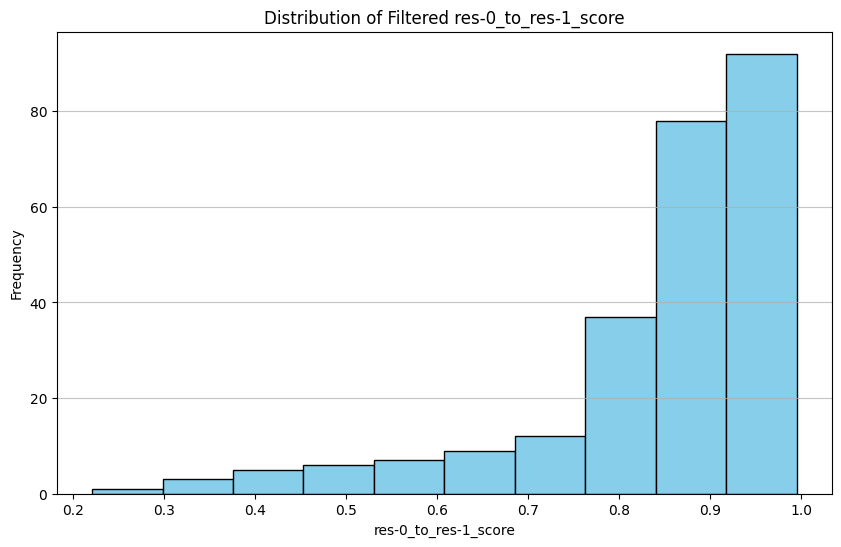

In [83]:
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['res-0_to_res-1_score'], color='skyblue', edgecolor='black')
plt.title('Distribution of Filtered res-0_to_res-1_score')
plt.xlabel('res-0_to_res-1_score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

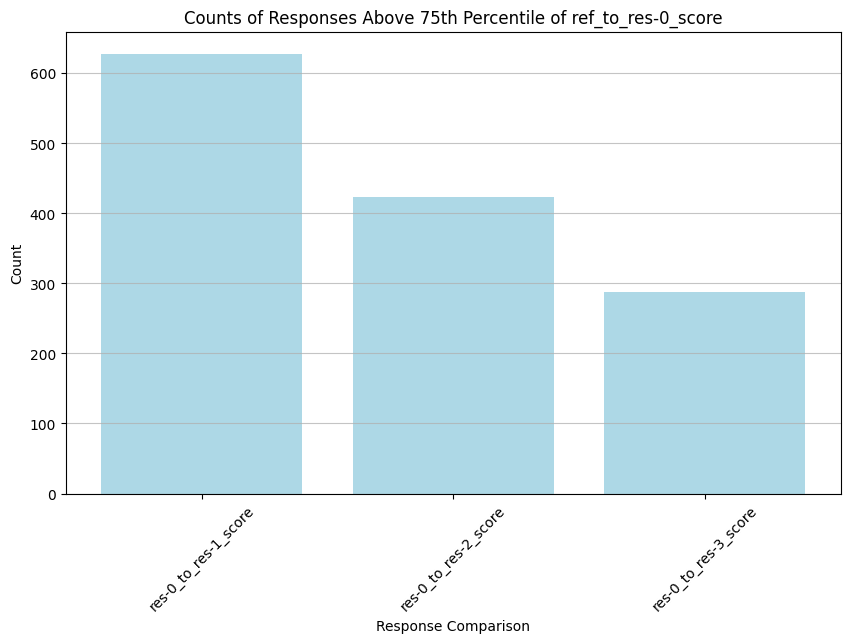

In [84]:

# Counting the number of scores above 'percentile_75' for each comparison
counts_above_percentile = {
    'res-0_to_res-1_score': (df['res-0_to_res-1_score'] > percentile_75).sum(),
    'res-0_to_res-2_score': (df['res-0_to_res-2_score'] > percentile_75).sum(),
    'res-0_to_res-3_score': (df['res-0_to_res-3_score'] > percentile_75).sum(),
}

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(counts_above_percentile.keys(), counts_above_percentile.values(), color='lightblue')
plt.title('Counts of Responses Above 75th Percentile of ref_to_res-0_score')
plt.xlabel('Response Comparison')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)

plt.show()
